In [6]:
!pip install torch torchvision tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import time


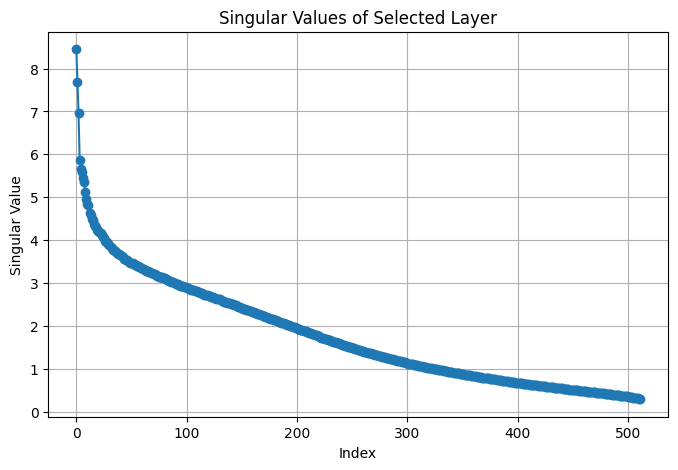

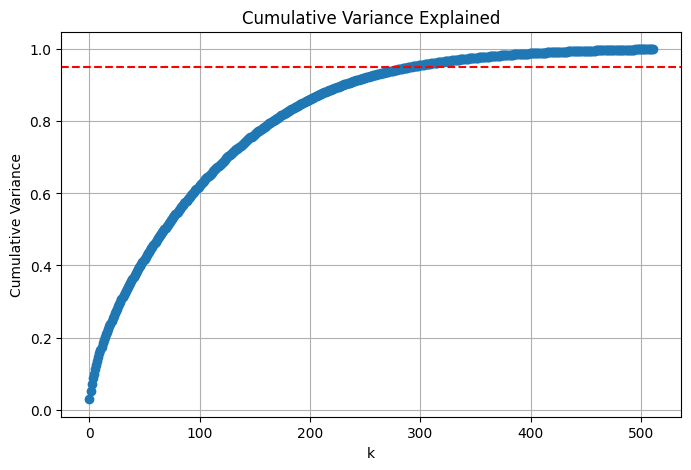

k to preserve 50% variance = 69
k to preserve 80% variance = 167
k to preserve 95% variance = 291


In [7]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testloader  = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(device)
model.eval()
target_layer = model.fc   # choose any intermediate layer you want
W = target_layer.weight.data.cpu().numpy()

U, S, Vt = np.linalg.svd(W, full_matrices=False)

plt.figure(figsize=(8,5))
plt.plot(S, marker='o')
plt.title("Singular Values of Selected Layer")
plt.xlabel("Index")
plt.ylabel("Singular Value")
plt.grid(True)
plt.show()

variance = (S**2) / np.sum(S**2)
cumulative = np.cumsum(variance)

plt.figure(figsize=(8,5))
plt.plot(cumulative, marker='o')
plt.axhline(0.95, color='r', linestyle='--')
plt.title("Cumulative Variance Explained")
plt.xlabel("k")
plt.ylabel("Cumulative Variance")
plt.grid(True)
plt.show()

for p in [0.5, 0.8, 0.95]:
    k = np.searchsorted(cumulative, p) + 1
    print(f"k to preserve {int(p*100)}% variance =", k)


In [8]:
from tqdm import tqdm

def low_rank_decompose_linear(layer: nn.Linear, rank_k: int):
    W = layer.weight.data.cpu().numpy()
    U, S, Vt = np.linalg.svd(W, full_matrices=False)

    Uk = U[:, :rank_k]
    Sk = np.diag(S[:rank_k])
    Vk = Vt[:rank_k, :]

    first = nn.Linear(Vk.shape[1], rank_k, bias=False)
    second = nn.Linear(rank_k, Uk.shape[0], bias=True)

    first.weight.data = torch.tensor(Vk, dtype=torch.float32)
    second.weight.data = torch.tensor(Uk @ Sk, dtype=torch.float32)
    second.bias.data = layer.bias.data.clone()

    return first, second


def compress_model(model, k):
    new_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    new_model.load_state_dict(model.state_dict())

    orig_fc = new_model.fc
    L1, L2 = low_rank_decompose_linear(orig_fc, k)
    new_model.fc = nn.Sequential(L1, L2)

    return new_model.to(device)

def evaluate(model):
    print("model eval")
    model.eval()
    correct = 0
    total = 0
    print("start counting corrects")
    with torch.no_grad():
        for x,y in tqdm(testloader):
            x,y = x.to(device), y.to(device)
            logits = model(x)
            _, pred = logits.max(1)
            correct += pred.eq(y).sum().item()
            total += y.size(0)
    return correct/total

def count_params(model):
    return sum(p.numel() for p in model.parameters())

print("evaluating original model ...")
acc_orig = evaluate(model)
print("counting original model ...")
params_orig = count_params(model)

# Compute k values
k_80 = int(S.shape[0] * 0.2)
k_50 = int(S.shape[0] * 0.5)

print("compressing model to 80 ...")
compressed_80 = compress_model(model, k_80)
print("compressing model to 50 ...")
compressed_50 = compress_model(model, k_50)

print("evaluating 80 model ...")
acc_80 = evaluate(compressed_80)
print("evaluating 50 model ...")
acc_50 = evaluate(compressed_50)

print("counting 80 model ...")
params_80 = count_params(compressed_80)
print("counting 80 model ...")
params_50 = count_params(compressed_50)

print("Original Accuracy:", acc_orig)
print("Compressed 80% Accuracy:", acc_80)
print("Compressed 50% Accuracy:", acc_50)

print("Parameter Counts:")
print("Original:", params_orig)
print("80%:", params_80)
print("50%:", params_50)


compressing model to 80 ...
compressing model to 50 ...
evaluating 80 model ...
model eval
start counting corrects


100%|██████████| 157/157 [14:35<00:00,  5.57s/it]


evaluating 50 model ...
model eval
start counting corrects


100%|██████████| 157/157 [14:35<00:00,  5.58s/it]

counting 80 model ...
counting 80 model ...
Original Accuracy: 0.0
Compressed 80% Accuracy: 0.0
Compressed 50% Accuracy: 0.0
Parameter Counts:
Original: 11689512
80%: 11331736
50%: 11564584


step 3

In [ ]:
def finetune(model, epochs=3, lr=1e-4):
    model.train()
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        for x,y in tqdm(trainloader, desc=f"Epoch {epoch+1}"):
            x,y = x.to(device), y.to(device)
            opt.zero_grad()
            loss = nn.CrossEntropyLoss()(model(x), y)
            loss.backward()
            opt.step()
    return model

compressed_80_ft = finetune(compressed_80, epochs=3)
acc_80_ft = evaluate(compressed_80_ft)
print("Fine-tuned 80% compressed accuracy:", acc_80_ft)

model_cpu = model.to("cpu").eval()

def measure_latency(model, runs=50):
    x = torch.randn(1,3,224,224)
    times = []
    with torch.no_grad():
        for _ in range(runs):
            t0 = time.time()
            model(x)
            times.append(time.time()-t0)
    return np.mean(times)

lat_orig = measure_latency(model_cpu)
lat_80   = measure_latency(compressed_80.to("cpu"))
lat_50   = measure_latency(compressed_50.to("cpu"))

print("CPU Latency (seconds):")
print("Original:", lat_orig)
print("80% compressed:", lat_80)
print("50% compressed:", lat_50)

compression_rates = [1.0, 0.8, 0.5]
accuracies = [acc_orig, acc_80, acc_50]

plt.figure(figsize=(7,5))
plt.plot(compression_rates, accuracies, marker='o')
plt.title("Accuracy vs Compression Rate")
plt.xlabel("Compression Rate")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


Epoch 1:  64%|██████▍   | 504/782 [2:16:31<1:15:17, 16.25s/it]